# Soil Heat Tutorial

This tutorial shows how to use CliMA code to solve the heat
equation in soil.
For background on the heat equation in general,
and how to solve it using CliMA code, please see the
[`heat_equation.jl`](../../Heat/heat_equation.md)
tutorial.

The version of the heat equation we are solving here assumes no
sources or sinks and no diffusion of liquid water. It takes the form
``
\frac{∂ ρe_int}{∂ t} + ∇ ⋅ (-κ(θ_l, θ_i; ν, ...) ∇T) = 0
``

Here `ρe_int` is the volumetric internal energy of the soil (J/m^3),
`T` is the temperature of the soil (K), and `κ` is the thermal conductivity
(W/m/K). `κ` is in turn a function of the soil composition, expressed
in terms of the volumetric liquid water fraction `θ_l`, the volumetric
ice fraction `θ_i`, and the soil type, represented by parameters `ν, ...`. Specifying
a soil type requires specifying the fraction of soil solids in different
components, and specifying a porosity. The temperature `T` and
volumetric internal energy `ρe_int` are related as
``
ρe_int = ρc_s (θ_l, θ_i; ν, ...) (T - T_0) - θ_i ρ_i LH_f0
``

where `ρc_s` is the volumetric heat capacity of the soil (J/m^3/K),
`T_0` is the freezing temeprature of water, `ρ_i` is the density of
ice (kg/m^3), and `LH_f0` is the latent heat of fusion at `T_0`.

In this example, we will use a [`PrescribedWaterModel`](@ref
ClimateMachine.Land.PrescribedWaterModel). This option allows
the user to specify a function for the spatial and temporal
behavior of `θ_i` and `θ_l`; it does not solve Richard's equation
for the evolution of moisture. Please see the tutorials
in the `Coupled/` or `Water/` folder for information on solving
Richard's equation, either coupled or uncoupled from the heat equation.

# Import necessary modules

External (non - CliMA) modules

In [1]:
using MPI
using OrderedCollections
using StaticArrays
using Statistics
using Dierckx
using Plots
using DelimitedFiles

CliMA Parameters

In [2]:
using CLIMAParameters
using CLIMAParameters.Planet: ρ_cloud_liq, ρ_cloud_ice, cp_l, cp_i, T_0, LH_f0
using CLIMAParameters.Atmos.Microphysics: K_therm

ClimateMachine modules

In [3]:
using ClimateMachine
using ClimateMachine.Land
using ClimateMachine.Land.SoilWaterParameterizations
using ClimateMachine.Land.SoilHeatParameterizations
using ClimateMachine.Mesh.Topologies
using ClimateMachine.Mesh.Grids
using ClimateMachine.DGMethods
using ClimateMachine.DGMethods.NumericalFluxes
using ClimateMachine.DGMethods: BalanceLaw, LocalGeometry
using ClimateMachine.MPIStateArrays
using ClimateMachine.GenericCallbacks
using ClimateMachine.ODESolvers
using ClimateMachine.VariableTemplates
using ClimateMachine.SingleStackUtils
using ClimateMachine.BalanceLaws:
    BalanceLaw, Prognostic, Auxiliary, Gradient, GradientFlux, vars_state
import ClimateMachine.DGMethods: calculate_dt
using ClimateMachine.ArtifactWrappers

# Preliminary set-up

Get the parameter set, which holds constants used across CliMA models.

In [4]:
struct EarthParameterSet <: AbstractEarthParameterSet end
const param_set = EarthParameterSet()

Main.##348.EarthParameterSet()

Initialize and pick a floating point precision.

In [5]:
ClimateMachine.init()
FT = Float32

const clima_dir = dirname(dirname(pathof(ClimateMachine)));

Load a function that will interpolate output of simulation

In [6]:
include(joinpath(
    clima_dir,
    "tutorials",
    "Land",
    "Soil",
    "interpolation_helper.jl",
));

# Determine soil parameters

This tutorial also compares the output of a ClimateMachine simulation with that
of Supplemental Program 2, Chapter 5, of Bonan (2019) [1].
 We found this useful as it
allows us compare results from our code against a published version.

The simulation code of [1] employs a formalism for the thermal
conductivity `κ` based on Johansen, 1975, [2]. It assumes
no organic matter, and only requires the volumetric
fraction of soil solids for quartz and other minerals.
ClimateMachine employs the formalism of Balland and Arp (2005)[3],
which requires the
fraction of soil solids for quartz, gravel,
organic matter, and other minerals. Dai (2019)[4] found
model [3] to better match
measured soil properties across a range of soil types.

To compare the output of the two simulations, we set the organic
matter content and gravel content to zero in the CliMA model.
The remaining soil components (quartz and other minerals) match between
the two. We also run the simulation for relatively wet soil
(water content at 80% of porosity). Under these conditions,
the two formulations for `κ`, though taking different functional forms,
agree well on the value of `κ`.
The differences between models are important
for soil with organic material and for soil that is relatively dry.

Below are the soil component fractions for various soil
texture classes,  from Cosby et al. (1984) [1, 5].
Note that these fractions are volumetric fractions, relative
to other soil solids, i.e. not including pore space. These are denoted `ν_ss_i`: an
important distinction is that the CliMA
Land Documentation reserves the symbol `ν_i` to denote the volumetric fraction
of a soil component `i` relative to the soil, including pore space, such that
the sum over `i`, of `ν_i`, is equal to `1-porosity`.

index: type

 1: sand

 2: loamy sand

 3: sandy loam

 4: silty loam

 5: loam

 6: sandy clay loam

 7  silty clay loam

 8: clay loam

 9: sandy clay

10: silty clay

11: clay

In [7]:
ν_ss_silt_array =
    FT.(
        [5.0, 12.0, 32.0, 70.0, 39.0, 15.0, 56.0, 34.0, 6.0, 47.0, 20.0] ./
        100.0,
    )
ν_ss_quartz_array =
    FT.(
        [92.0, 82.0, 58.0, 17.0, 43.0, 58.0, 10.0, 32.0, 52.0, 6.0, 22.0] ./
        100.0,
    )
ν_ss_clay_array =
    FT.(
        [3.0, 6.0, 10.0, 13.0, 18.0, 27.0, 34.0, 34.0, 42.0, 47.0, 58.0] ./
        100.0,
    )
porosity_array =
    FT.([
        0.395,
        0.410,
        0.435,
        0.485,
        0.451,
        0.420,
        0.477,
        0.476,
        0.426,
        0.492,
        0.482,
    ])

11-element Array{Float32,1}:
 0.395
 0.41
 0.435
 0.485
 0.451
 0.42
 0.477
 0.476
 0.426
 0.492
 0.482

Here we choose the soil type to be sandy.
The soil column in uniform in space and time.

In [8]:
soil_type_index = 1
ν_ss_minerals =
    ν_ss_clay_array[soil_type_index] + ν_ss_silt_array[soil_type_index]
ν_ss_quartz = ν_ss_quartz_array[soil_type_index]
porosity = porosity_array[soil_type_index]

0.395f0

To match the formulation for `κ` [2] used in [1]:

In [9]:
ν_ss_om = FT(0.0)
ν_ss_gravel = FT(0.0)

0.0f0

Now that we've chosen our soil type, we can calculate
the thermal conductivity `κ` of the soil. This requires
several other constants:

In [10]:
κ_quartz = FT(7.7) # W/m/K
κ_minerals = FT(2.5) # W/m/K
κ_om = FT(0.25) # W/m/K
κ_liq = FT(0.57) # W/m/K
κ_ice = FT(2.29) # W/m/K

2.29f0

The thermal conductivity of air is a constant parameter used across ClimateMachine,
so we will get it from that parameter set.

In [11]:
κ_air = FT(K_therm(param_set)) # W/m/K

κ_solid =
    k_solid(ν_ss_om, ν_ss_quartz, ν_ss_minerals, κ_quartz, κ_minerals, κ_om)

7.03731f0

The particle density of soil solids in moisture-free soil
is taken as a constant, across soil types, as in [1].
This is a good estimate for organic material free soil. The user is referred to
[3] for a more general expression.

In [12]:
ρp = FT(2700) # kg/m^3
κ_dry = k_dry(κ_solid, porosity, κ_air, ρp)
κ_sat_frozen = ksat_frozen(κ_solid, porosity, κ_ice)
κ_sat_unfrozen = ksat_unfrozen(κ_solid, porosity, κ_liq)

2.6076639f0

The volumetric specific heat of dry soil is chosen so as to match Bonan's simulation.
The user could instead compute this as:
``ρc_{ds} = (1-porosity) \sum_i ν_ss_i ρcν_i``
where `i` ranges over soil components, `ν_ss_i` is the volumetric fraction of
soil component `i`, relative to the soil solids, and `ρcν_i` is the volumetric heat
capacity of that component.

In [13]:
ρc_ds = FT((1 - porosity) * 1.926e06) # J/m^3/K

soil_param_functions = SoilParamFunctions{FT}(
    porosity = porosity,
    ν_ss_gravel = ν_ss_gravel,
    ν_ss_om = ν_ss_om,
    ν_ss_quartz = ν_ss_quartz,
    ρc_ds = ρc_ds,
    κ_dry = κ_dry,
    κ_sat_unfrozen = κ_sat_unfrozen,
    κ_sat_frozen = κ_sat_frozen,
    a = 0.24, # used in the Kersten number [3]
    b = 18.1, # used in the Kersten number [3]
)

ClimateMachine.Land.SoilParamFunctions{Float32}(0.395f0, NaN32, NaN32, 0.0f0, 0.0f0, 0.92f0, 1.16523f6, 0.55057514f0, 2.6076639f0, 4.5166464f0, 0.24f0, 18.1f0)

# Initial and Boundary conditions
We will be using a `PrescribedWaterModel`, where the user supplies the augmented
liquid fraction and ice fraction as functions of space and time. Since we are not
implementing phase changes, it makes sense to either have entirely liquid or
frozen water. This tutorial shows liquid water.

Because the two models for thermal conductivity agree well for wetter soil, we'll
choose that here. However, the user could also explore how they differ by choosing
drier soil.

Please note that if the user uses a mix of liquid and frozen water, that they must
ensure that the total water content does not exceed porosity.

In [14]:
prescribed_augmented_liquid_fraction = FT(porosity * 0.8)
prescribed_volumetric_ice_fraction = FT(0.0)

0.0f0

Choose boundary conditions for heat that will not lead to freezing of water:

In [15]:
heat_surface_state = (aux, t) -> eltype(aux)(288.15)
heat_bottom_flux = (aux, t) -> eltype(aux)(0.0)
T_init = (aux) -> eltype(aux)(275.15)

#5 (generic function with 1 method)

We also need to define a function `init_soil!`, which
initializes all of the prognostic variables (here, we
only have `ρe_int`, the volumetric internal energy).
The initialization is based on user-specified
initial conditions. Note that the user provides initial
conditions for heat based on the temperature - `init_soil!` also
converts between `T` and `ρe_int`.

In [16]:
function init_soil!(land, state, aux, coordinates, time)
    ϑ_l, θ_i = get_water_content(land.soil.water, aux, state, time)
    θ_l = volumetric_liquid_fraction(ϑ_l, land.soil.param_functions.porosity)
    ρc_ds = land.soil.param_functions.ρc_ds
    ρc_s = volumetric_heat_capacity(θ_l, θ_i, ρc_ds, land.param_set)

    state.soil.heat.ρe_int = volumetric_internal_energy(
        θ_i,
        ρc_s,
        land.soil.heat.initialT(aux),
        land.param_set,
    )
end

init_soil! (generic function with 1 method)

# Create the soil model structure

In [17]:
soil_water_model = PrescribedWaterModel(
    (aux, t) -> prescribed_augmented_liquid_fraction,
    (aux, t) -> prescribed_volumetric_ice_fraction,
)

soil_heat_model = SoilHeatModel(
    FT;
    initialT = T_init,
    dirichlet_bc = Dirichlet(
        surface_state = heat_surface_state,
        bottom_state = nothing,
    ),
    neumann_bc = Neumann(
        surface_flux = nothing,
        bottom_flux = heat_bottom_flux,
    ),
)

m_soil = SoilModel(soil_param_functions, soil_water_model, soil_heat_model)
sources = ()
m = LandModel(
    param_set,
    m_soil;
    source = sources,
    init_state_prognostic = init_soil!,
)

ClimateMachine.Land.LandModel{Main.##348.EarthParameterSet,ClimateMachine.Land.SoilModel{ClimateMachine.Land.SoilParamFunctions{Float32},ClimateMachine.Land.PrescribedWaterModel{Main.##348.var"#7#9",Main.##348.var"#8#10"},ClimateMachine.Land.SoilHeatModel{Float32,Main.##348.var"#5#6",ClimateMachine.Land.Dirichlet{Main.##348.var"#1#2",Nothing},ClimateMachine.Land.Neumann{Nothing,Main.##348.var"#3#4"}}},Tuple{},typeof(Main.##348.init_soil!)}(Main.##348.EarthParameterSet(), ClimateMachine.Land.SoilModel{ClimateMachine.Land.SoilParamFunctions{Float32},ClimateMachine.Land.PrescribedWaterModel{Main.##348.var"#7#9",Main.##348.var"#8#10"},ClimateMachine.Land.SoilHeatModel{Float32,Main.##348.var"#5#6",ClimateMachine.Land.Dirichlet{Main.##348.var"#1#2",Nothing},ClimateMachine.Land.Neumann{Nothing,Main.##348.var"#3#4"}}}(ClimateMachine.Land.SoilParamFunctions{Float32}(0.395f0, NaN32, NaN32, 0.0f0, 0.0f0, 0.92f0, 1.16523f6, 0.55057514f0, 2.6076639f0, 4.5166464f0, 0.24f0, 18.1f0), ClimateMachine.La

# Specify the numerical details
These include the resolution, domain boundaries, integration time,
Courant number, and ODE solver.

In [18]:
N_poly = 1
nelem_vert = 100

zmax = FT(0)
zmin = FT(-1)

driver_config = ClimateMachine.SingleStackConfiguration(
    "LandModel",
    N_poly,
    nelem_vert,
    zmax,
    param_set,
    m;
    zmin = zmin,
    numerical_flux_first_order = CentralNumericalFluxFirstOrder(),
)

┌ Info: Model composition
│     param_set = Main.##348.EarthParameterSet()
│     soil = ClimateMachine.Land.SoilModel{ClimateMachine.Land.SoilParamFunctions{Float32},ClimateMachine.Land.PrescribedWaterModel{Main.##348.var"#7#9",Main.##348.var"#8#10"},ClimateMachine.Land.SoilHeatModel{Float32,Main.##348.var"#5#6",ClimateMachine.Land.Dirichlet{Main.##348.var"#1#2",Nothing},ClimateMachine.Land.Neumann{Nothing,Main.##348.var"#3#4"}}}(ClimateMachine.Land.SoilParamFunctions{Float32}(0.395f0, NaN32, NaN32, 0.0f0, 0.0f0, 0.92f0, 1.16523f6, 0.55057514f0, 2.6076639f0, 4.5166464f0, 0.24f0, 18.1f0), ClimateMachine.Land.PrescribedWaterModel{Main.##348.var"#7#9",Main.##348.var"#8#10"}(Main.##348.var"#7#9"(), Main.##348.var"#8#10"()), ClimateMachine.Land.SoilHeatModel{Float32,Main.##348.var"#5#6",ClimateMachine.Land.Dirichlet{Main.##348.var"#1#2",Nothing},ClimateMachine.Land.Neumann{Nothing,Main.##348.var"#3#4"}}(Main.##348.var"#5#6"(), ClimateMachine.Land.Dirichlet{Main.##348.var"#1#2",Nothing}(Main

ClimateMachine.DriverConfiguration{Float32}(ClimateMachine.ConfigTypes.SingleStackConfigType(), "LandModel", 1, Array, ExplicitSolverType(ClimateMachine.ODESolvers.LSRK54CarpenterKennedy), Main.##348.EarthParameterSet(), ClimateMachine.Land.LandModel{Main.##348.EarthParameterSet,ClimateMachine.Land.SoilModel{ClimateMachine.Land.SoilParamFunctions{Float32},ClimateMachine.Land.PrescribedWaterModel{Main.##348.var"#7#9",Main.##348.var"#8#10"},ClimateMachine.Land.SoilHeatModel{Float32,Main.##348.var"#5#6",ClimateMachine.Land.Dirichlet{Main.##348.var"#1#2",Nothing},ClimateMachine.Land.Neumann{Nothing,Main.##348.var"#3#4"}}},Tuple{},typeof(Main.##348.init_soil!)}(Main.##348.EarthParameterSet(), ClimateMachine.Land.SoilModel{ClimateMachine.Land.SoilParamFunctions{Float32},ClimateMachine.Land.PrescribedWaterModel{Main.##348.var"#7#9",Main.##348.var"#8#10"},ClimateMachine.Land.SoilHeatModel{Float32,Main.##348.var"#5#6",ClimateMachine.Land.Dirichlet{Main.##348.var"#1#2",Nothing},ClimateMachine.La

In this tutorial, we determine a timestep based on a Courant number (
also called a Fourier number in the context of the heat equation).
In short, we can use the parameters of the model (`κ` and `ρc_s`),
along with with the size of
elements of the grid used for discretizing the PDE, to estimate
a natural timescale for heat transfer across a grid cell.
Because we are using an explicit ODE solver, the timestep should
be a fraction of this in order to resolve the dynamics.

This allows us to automate, to a certain extent, choosing a value for
the timestep, even as we switch between soil types.

In [19]:
function calculate_dt(dg, model::LandModel, Q, Courant_number, t, direction)
    Δt = one(eltype(Q))
    CFL = DGMethods.courant(diffusive_courant, dg, model, Q, Δt, t, direction)
    return Courant_number / CFL
end

function diffusive_courant(
    m::LandModel,
    state::Vars,
    aux::Vars,
    diffusive::Vars,
    Δx,
    Δt,
    t,
    direction,
)
    soil = m.soil
    ϑ_l, θ_i = get_water_content(soil.water, aux, state, t)
    θ_l = volumetric_liquid_fraction(ϑ_l, soil.param_functions.porosity)
    κ_dry = soil.param_functions.κ_dry
    S_r = relative_saturation(θ_l, θ_i, soil.param_functions.porosity)
    kersten = kersten_number(θ_i, S_r, soil.param_functions)
    κ_sat = saturated_thermal_conductivity(
        θ_l,
        θ_i,
        soil.param_functions.κ_sat_unfrozen,
        soil.param_functions.κ_sat_frozen,
    )
    κ = thermal_conductivity(κ_dry, kersten, κ_sat)
    ρc_ds = soil.param_functions.ρc_ds
    ρc_s = volumetric_heat_capacity(θ_l, θ_i, ρc_ds, m.param_set)
    return Δt * κ / (Δx * Δx * ρc_ds)
end


t0 = FT(0)
timeend = FT(60 * 60 * 3)
Courant_number = FT(0.5) # much bigger than this breaks

solver_config = ClimateMachine.SolverConfiguration(
    t0,
    timeend,
    driver_config;
    Courant_number = Courant_number,
    CFL_direction = VerticalDirection(),
)

┌ Info: Initializing LandModel
└ @ ClimateMachine /home/runner/work/ClimateMachine.jl/ClimateMachine.jl/src/Driver/solver_configs.jl:161


ClimateMachine.SolverConfiguration{Float32}("LandModel", MPI.Comm(1140850688), Main.##348.EarthParameterSet(), ClimateMachine.DGMethods.DGModel{ClimateMachine.Land.LandModel{Main.##348.EarthParameterSet,ClimateMachine.Land.SoilModel{ClimateMachine.Land.SoilParamFunctions{Float32},ClimateMachine.Land.PrescribedWaterModel{Main.##348.var"#7#9",Main.##348.var"#8#10"},ClimateMachine.Land.SoilHeatModel{Float32,Main.##348.var"#5#6",ClimateMachine.Land.Dirichlet{Main.##348.var"#1#2",Nothing},ClimateMachine.Land.Neumann{Nothing,Main.##348.var"#3#4"}}},Tuple{},typeof(Main.##348.init_soil!)},ClimateMachine.Mesh.Grids.DiscontinuousSpectralElementGrid{Float32,3,1,8,Array,Array{Float32,1},Array{Float32,2},Array{Float32,3},Array{Float32,4},Array{Int64,1},Array{Int64,2},Array{Int64,3},ClimateMachine.Mesh.Topologies.StackedBrickTopology{3,Float32}},ClimateMachine.DGMethods.NumericalFluxes.CentralNumericalFluxFirstOrder,ClimateMachine.DGMethods.NumericalFluxes.CentralNumericalFluxSecondOrder,ClimateMach

# Run the integration

In [20]:
ClimateMachine.invoke!(solver_config)

┌ Info: Starting LandModel
│     dt              = 2.38938e+01
│     timeend         = 10800.00
│     number of steps = 452
│     norm(Q)         = 4.9479710000000000e+06
└ @ ClimateMachine /home/runner/work/ClimateMachine.jl/ClimateMachine.jl/src/Driver/Driver.jl:636
┌ Info: Finished
│     norm(Q)            = 1.1510868000000000e+07
│     norm(Q) / norm(Q₀) = 2.3263814449310303e+00
│     norm(Q) - norm(Q₀) = 6.5628970000000000e+06
└ @ ClimateMachine /home/runner/work/ClimateMachine.jl/ClimateMachine.jl/src/Driver/Driver.jl:674


2.3263814f0

# Plot results
Pull out the z and T values on the grid, but interpolate.
The solution from DG is discontinuous at boundaries of elements.
The `interpolate_output` function smooths over these.

In [21]:
zres = 0.02

0.02

T and z are in aux:

In [22]:
aux = solver_config.dg.state_auxiliary

8×2×100 ClimateMachine.MPIStateArrays.MPIStateArray{Float32,NamedTuple{(:z, :soil),Tuple{Float32,NamedTuple{(:water, :heat),Tuple{NamedTuple{(),Tuple{}},NamedTuple{(:T,),Tuple{Float32}}}}}},Array{Float32,3},Array{Int64,1},SubArray{Float32,3,Array{Float32,3},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true},ClimateMachine.MPIStateArrays.CMBuffers.CMBuffer{Float32,Array{Float32,2},Nothing}}:
[:, :, 1] =
 -1.0   275.15
 -1.0   275.15
 -1.0   275.15
 -1.0   275.15
 -0.99  275.15
 -0.99  275.15
 -0.99  275.15
 -0.99  275.15

[:, :, 2] =
 -0.99  275.15
 -0.99  275.15
 -0.99  275.15
 -0.99  275.15
 -0.98  275.15
 -0.98  275.15
 -0.98  275.15
 -0.98  275.15

[:, :, 3] =
 -0.98  275.15
 -0.98  275.15
 -0.98  275.15
 -0.98  275.15
 -0.97  275.15
 -0.97  275.15
 -0.97  275.15
 -0.97  275.15

...

[:, :, 98] =
 -0.03  286.374
 -0.03  286.374
 -0.03  286.374
 -0.03  286.374
 -0.02  286.374
 -0.02  286.374
 -0.02  286.374
 -0.02  286.374

[:, :, 99] =
 -0.02  

ρe_int is stored in the state:

In [23]:
Q = solver_config.Q

8×1×100 ClimateMachine.MPIStateArrays.MPIStateArray{Float32,NamedTuple{(:soil,),Tuple{NamedTuple{(:water, :heat),Tuple{NamedTuple{(),Tuple{}},NamedTuple{(:ρe_int,),Tuple{Float32}}}}}},Array{Float32,3},Array{Int64,1},SubArray{Float32,3,Array{Float32,3},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true},ClimateMachine.MPIStateArrays.CMBuffers.CMBuffer{Float32,Array{Float32,2},Nothing}}:
[:, :, 1] =
 4.9480085f6
 4.948033f6
 4.948033f6
 4.947999f6
 4.948008f6
 4.9480035f6
 4.9480035f6
 4.948f6

[:, :, 2] =
 4.9479795f6
 4.9479755f6
 4.9479755f6
 4.94802f6
 4.947991f6
 4.948021f6
 4.948021f6
 4.9480065f6

[:, :, 3] =
 4.948004f6
 4.9480265f6
 4.9480265f6
 4.948015f6
 4.948003f6
 4.947985f6
 4.947985f6
 4.9479585f6

...

[:, :, 98] =
 3.2856162f7
 3.2856168f7
 3.2856168f7
 3.285617f7
 3.2856312f7
 3.2856308f7
 3.2856308f7
 3.2856306f7

[:, :, 99] =
 3.4613944f7
 3.4613956f7
 3.4613956f7
 3.4613936f7
 3.4614016f7
 3.4613988f7
 3.4613988f7
 3.4614016f7



gradients that might be interesting to look at are stored here:

In [24]:
grads = solver_config.dg.state_gradient_flux

8×3×100 ClimateMachine.MPIStateArrays.MPIStateArray{Float32,NamedTuple{(:soil,),Tuple{NamedTuple{(:water, :heat),Tuple{NamedTuple{(),Tuple{}},NamedTuple{(:κ∇T,),Tuple{StaticArrays.SArray{Tuple{3},Float32,1,3}}}}}}},Array{Float32,3},Array{Int64,1},SubArray{Float32,3,Array{Float32,3},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true},ClimateMachine.MPIStateArrays.CMBuffers.CMBuffer{Float32,Array{Float32,2},Nothing}}:
[:, :, 1] =
  0.0           0.0           0.00742949
  0.0           0.0          -0.00742953
  0.0           0.0          -0.00742953
  0.0           0.0           0.00742953
  2.21416f-10   2.21416f-10   0.00742949
 -2.21417f-10  -2.21417f-10  -0.00742953
 -2.21417f-10  -2.21417f-10  -0.00742953
  2.21417f-10   2.21417f-10   0.00742953

[:, :, 2] =
 -7.27597f-10  -7.27597f-10  -0.0244141
  2.21417f-10   2.21417f-10   0.00742953
  2.21417f-10   2.21417f-10   0.00742953
 -2.21416f-10  -2.21416f-10  -0.00742949
  0.0           0.0       

Smooth output, and look at T vs z:

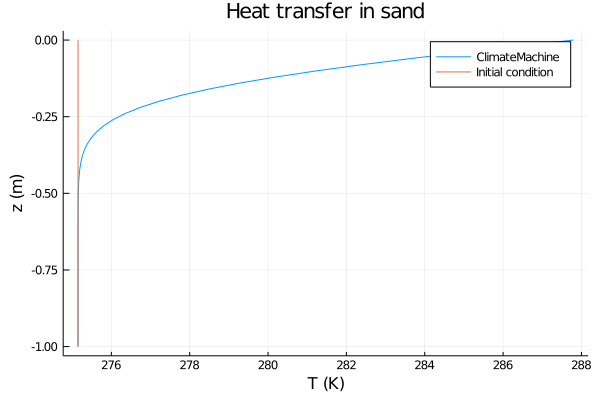

In [25]:
iQ, iaux, igrads =
    interpolate_output(solver_config.dg.grid, zmin, zmax, Q, aux, grads, zres)
z_ind = varsindex(vars_state(m, Auxiliary(), FT), :z)
iz = Array(iaux[:, z_ind, :][:])
z = Array(aux[:, z_ind, :][:])
T_ind = varsindex(vars_state(m, Auxiliary(), FT), :soil, :heat, :T)
iT = Array(iaux[:, T_ind, :][:])

plot(
    iT,
    iz,
    label = "ClimateMachine",
    ylabel = "z (m)",
    xlabel = "T (K)",
    title = "Heat transfer in sand",
)
plot!(T_init.(z), z, label = "Initial condition")

# Comparison data

In [26]:
filename = "bonan_heat_data.csv"
const clima_dir = dirname(dirname(pathof(ClimateMachine)));
bonan_dataset = ArtifactWrapper(
    joinpath(clima_dir, "tutorials", "Land", "Soil", "Artifacts.toml"),
    "bonan_soil_heat",
    ArtifactFile[ArtifactFile(
        url = "https://caltech.box.com/shared/static/99vm8q8tlyoulext6c35lnd3355tx6bu.csv",
        filename = filename,
    ),],
)
bonan_dataset_path = get_data_folder(bonan_dataset)
data = joinpath(bonan_dataset_path, filename)
ds_bonan = readdlm(data, ',')
bonan_T = reverse(ds_bonan[:, 2])
bonan_z = reverse(ds_bonan[:, 1])

101-element Array{Float64,1}:
 -0.995
 -0.985
 -0.975
 -0.965
 -0.955
 -0.945
 -0.935
 -0.925
 -0.915
 -0.905
  ⋮
 -0.075
 -0.065
 -0.055
 -0.045
 -0.035
 -0.025
 -0.015
 -0.005
  0.0

Create an interpolation from the Bonan data

In [27]:
bonan_T_continuous = Spline1D(bonan_z, bonan_T)
bonan_at_clima_z = bonan_T_continuous.(z)

plot!(bonan_at_clima_z, z, label = "Bonan simulation")
plot!(legend = :bottomleft)
savefig("thermal_conductivity_comparison.png")

![](thermal_conductivity_comparison.png)

The plot shows that the temperature at the top of the
soil is gradually increasing. This is because the surface
temperature is held fixed at a value larger than
the initial temperature. If we ran this for longer,
we would see that the bottom of the domain would also
increase in temperature because there is no heat
leaving the bottom (due to zero heat flux specified in
the boundary condition).

# References
[1] Bonan, G. Climate Change and Terrestrial Ecosystem Modeling (2019),
Cambridge University Press

[2] Johansen, O. 1975. Thermal conductivity of soils. Ph.D. thesis,
Trondheim, Norway. Cold Regions Research and Engineering Laboratory
Draft Translation 637, 1977, ADA 044002.

[3] Balland, V., and P. A. Arp (2005), Modeling soil thermal
conductivities over a wide range of conditions, J. Env. Eng. Sci., 4, 549–558.

[4] Dai, Y., N. W. amd Hua Yuan, S. Zhang, W. Shangguan, S. Liu, X. Lu,
and Y. Xin (2019a), Evaluation of soil thermal conductivity schemes for
use in land surface modeling, J. Adv. Model. Earth Sys., 11, 3454–3473.

[5] Cosby, B. J., Hornberger, G. M., Clapp, R. B., and Ginn, T. R. (1984).
A statistical exploration of the relationships of soil moisture
characteristics to the physical properties of soils. Water Resources
Research, 20, 682–690.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*